# GPcounts on bulk dataset

Nuha BinTayyash, 2020

This notebook shows how to run [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) R package to normalize [fission yeast](https://bioconductor.org/packages/release/data/experiment/html/fission.html) gene expression data. Then, compare GPcounts with negative binomial likelihood and Gaussian likelihood to find differentially expressed genes in one sample test and two-sample tests.

### load [fission dataset](https://bioconductor.org/packages/3.11/data/experiment/html/fission.html) and normalize it using DESeq2

In [ ]:
library("fission")
data("fission")
counts <- SummarizedExperiment::assay(fission)
keep <- rowMeans(counts) >1
counts <- counts[keep,]
col_data <- fission@colData
write.csv(counts, file = "fission_counts.csv")
write.csv(col_data, file = "fission_col_data.csv")

wt_counts <- counts[,1:18]
wt_col_data <- col_data[1:18,]
write.csv(wt_counts, file = "wt_counts.csv")
write.csv(wt_col_data, file = "wt_col_data.csv")
dim(counts)

DESeq2 two samples test

In [ ]:
#col_data_scaled <- read.csv(file = 'fission_col_data_scaled.csv',row.names = 1, header = TRUE)

library("DESeq2")
dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = col_data,
                              design = ~ strain + minute + strain:minute)

dds <- estimateSizeFactors(dds)
normalized_counts<-counts(dds, normalized=TRUE)
dim(normalized_counts)
write.csv(normalized_counts, file = "fission_normalized_counts.csv")

dds <- DESeq(dds, test="LRT", reduced = ~ strain + minute)
res <- results(dds)
write.csv(as.data.frame(res),file="fission_DESeq2_tst.csv")

In [ ]:
col_data_scaled <- read.csv(file = 'wt_col_data_scaled.csv',row.names = 1, header = TRUE)

dds <- DESeqDataSetFromMatrix(countData = wt_counts,
                              colData = col_data_scaled,
                              design = ~  minute)

dds <- estimateSizeFactors(dds)
normalized_counts<-counts(dds, normalized=TRUE)
write.csv(normalized_counts, file = "wt_normalized_counts.csv")

dds <- DESeq(dds, test="LRT", reduced = ~ 1)
res <- results(dds)
write.csv(as.data.frame(res),file="fission_DESeq2_ost.csv")

#### Change R kernel to Python kernel

In [1]:
import numpy as np
import pandas as pd
import gpflow

In [2]:
filename = 'fission_normalized_counts.csv'
#filename = 'wt_normalized_counts_scaled52.csv'
Y = pd.read_csv(filename,index_col=[0])
X = pd.read_csv('fission_col_data.csv',index_col=[0])
X = X[['minute']]
#X.iloc[0:18,:]

Fit some fission gene normalized data using GPcounts -- Two samples test

In [3]:
from matplotlib import pyplot as plt
import statsmodels.api as sm

def plot():
    plt.tick_params(labelsize='large', width=2)     
    #plt.ylabel('Gene Expression', fontsize=16)
    #plt.xlabel('Times', fontsize=16)
    c = 'royalblue'
    
    if model_index == 3:
        c = 'green'
    
    plt.plot(xtest, mean,color= c, lw=2) 
    
    if likelihood == 'Gaussian':
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 1*np.sqrt(var[:,0]),
                            mean[:,0] + 1*np.sqrt(var[:,0]),color=c,alpha=0.2) # one standard deviation
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 2*np.sqrt(var[:,0]),
                            mean[:,0] + 2*np.sqrt(var[:,0]),color=c, alpha=0.1)# two standard deviation
    else:
       
        lowess = sm.nonparametric.lowess    
        # one standard deviation 68%
        percentile_16 = lowess(np.percentile(var, 16, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_16 = [(i > 0) * i for i in percentile_16]
        percentile_84 = lowess(np.percentile(var, 84, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_84 = [(i > 0) * i for i in percentile_84]
        plt.fill_between(xtest[:,0],percentile_16,percentile_84,color=c,alpha=0.2)
        
        # two standard deviation 95%
        percentile_5 = lowess(np.percentile(var, 5, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_5 = [(i > 0) * i for i in percentile_5]
        percentile_95 = lowess(np.percentile(var,95, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_95 = [(i > 0) * i for i in percentile_95]
        plt.fill_between(xtest[:,0],percentile_5,percentile_95,color=c,alpha=0.1)
    
    if test == 'Two_samples_test' and model_index == 1:
        plt.scatter(model.data[0][0:int(model.data[0].shape[0]/2)],model.data[1][0:int(model.data[0].shape[0]/2)], s=30, marker='o', color= 'royalblue',alpha=1.) #data    
        plt.scatter(model.data[0][int(model.data[0].shape[0]/2)::],model.data[1][int(model.data[0].shape[0]/2)::], s=30, marker='o', color= 'green',alpha=1.) #data

    else: 
        plt.scatter(model.data[0],model.data[1],s=30,marker = 'o',color=c,alpha=1.)
    
    
    if not(test == 'Two_samples_test' and model_index == 2):
        plt.show()
    

In [32]:
from GPcounts.GPcounts_Module import Fit_GPcounts
likelihood = 'Negative_binomial' 
genes_name = [
 'SPAPB1A11.02','SPNCRNA.750','SPNCRNA.827','SPAC1B3.16c'
]
gp_counts = Fit_GPcounts(X,Y.loc[genes_name])
results = gp_counts.Two_samples_test(likelihood)
results['likelihood']

100%|██████████| 4/4 [00:14<00:00,  3.75s/it]


,Shared_log_likelihood,model_1_log_likelihood,model_2_log_likelihood,log_likelihood_ratio
SPAPB1A11.02,-93.559876,-51.070291,-41.472279,1.017306
SPNCRNA.750,-75.253138,-42.218700,-31.948669,1.085769
SPNCRNA.827,-133.019367,-65.747886,-66.856387,0.415093
SPAC1B3.16c,-296.247452,-147.118218,-148.839533,0.289701


100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


SPAPB1A11.02


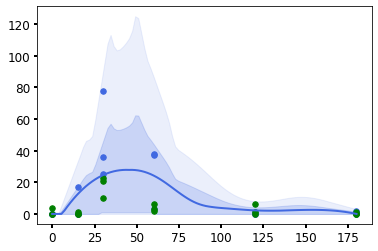

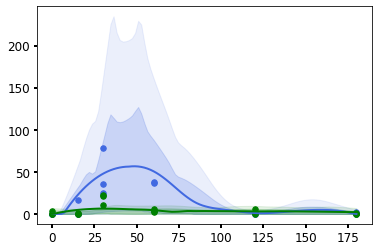

SPNCRNA.750


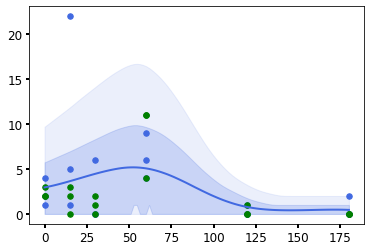

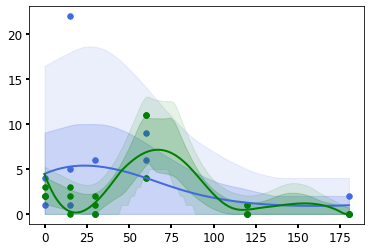

SPNCRNA.827


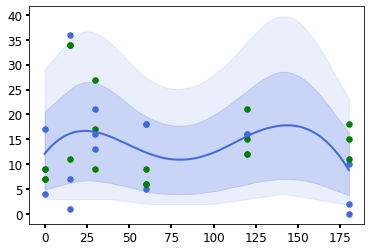

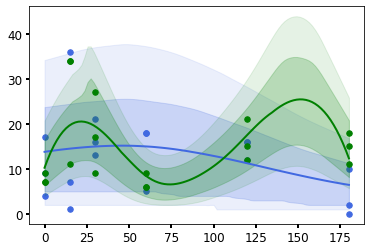

SPAC1B3.16c


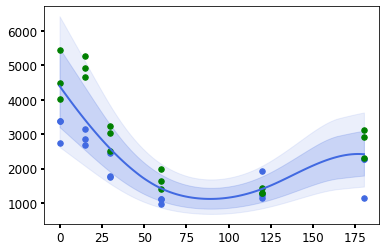

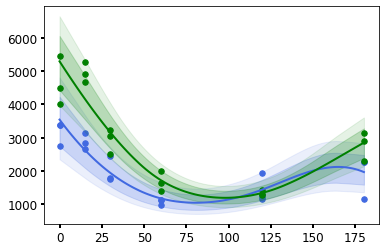

In [33]:
indexes = results['likelihood'].index.values # list of genes to be plotted 
test = 'Two_samples_test' # name of the test
xtest = np.linspace(np.min(X.values)-.1,np.max(X.values)+.1,100)[:,None] # points to make prediction
likelihood = 'Negative_binomial'
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for mean,var,model in zip(params['means'][i],params['vars'][i],params['models'][i]):
        plot() 
        model_index = model_index + 1

In [34]:
likelihood = 'Gaussian'
results = gp_counts.Two_samples_test(likelihood)
results['likelihood']

100%|██████████| 4/4 [00:02<00:00,  1.35it/s]


,Shared_log_likelihood,model_1_log_likelihood,model_2_log_likelihood,log_likelihood_ratio
SPAPB1A11.02,-54.478838,-31.101783,-25.624866,-2.247811
SPNCRNA.750,-42.980579,-25.441840,-18.933791,-1.395052
SPNCRNA.827,-44.228105,-25.686355,-18.929676,-0.387926
SPAC1B3.16c,-17.482712,-11.048921,-6.550544,-0.116753


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


SPAPB1A11.02


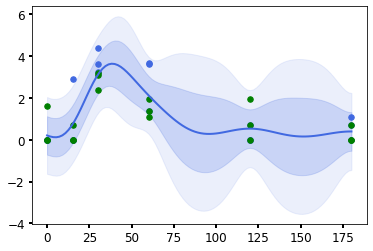

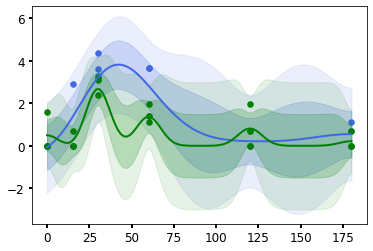

SPNCRNA.750


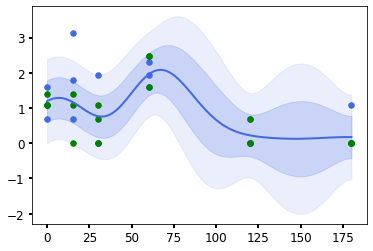

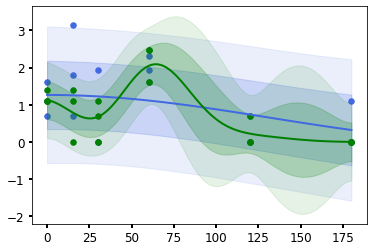

SPNCRNA.827


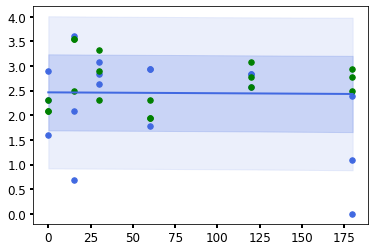

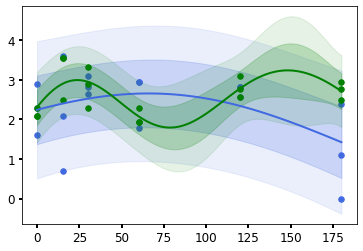

SPAC1B3.16c


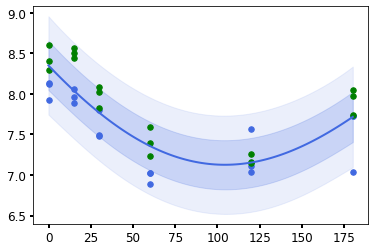

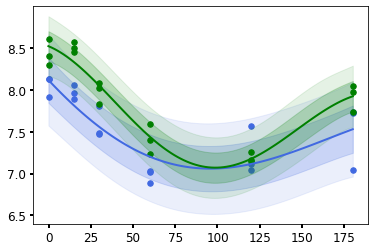

In [35]:
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        plot()
        model_index = model_index + 1

In [ ]:
from GPcounts.GPcounts_Module import Fit_GPcounts
likelihood = 'Negative_binomial' 
gp_counts = Fit_GPcounts(X.iloc[0:18,:],Y.iloc[:,0:18])
log_likelihood_ratio = gp_counts.One_sample_test(likelihood)
log_likelihood_ratio

In [ ]:
indexes = log_likelihood_ratio.index.values # list of genes to be plotted 
test = 'One_samples_test' # name of the test
xtest = np.linspace(np.min(X.values)-.1,np.max(X.values)+.1,100)[:,None] # points to make prediction

params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        plot()
        model_index = model_index + 1